#Variational auto-encoders for single-cell gene expression data

## Introduction
Single cell RNA sequencing is a method that allows the analyses of gene expssion at the individual cell level. In this scope, there is a pressing need for generative models that can capture complex patterns and varibility of gene expression data. To address this challenge the authors of [1] explored the efficiency of Variational Autoencoders (VAEs) which are probabilistic models evaluated by likelihood functions,  and Gaussian Mixture VAE (GMVAE) that incorporated clustering in the latent space.

This notebook presents the implementation of a Variational Autoencoder (VAE) and a Gaussian Mixture VAE from scratch, inspired by artitechtures discussed in [1]. The aim being to understand these generative models and evaluate their performance on synthetic data and real single gene expression data (MBC-20k)

## Background
### Variational Autoencoders (VAEs)
A VAE is a class of generative  models, which consist  of an encoder and a decoder that are interelated and yet independently parametrized models. The encoder maps the input data (gene expression counts) to a probabilistic distribution in the latent space that we chose to be a gaussian characterized by a mean and variance. The decoder then samples from this distribution to reconstruct the input data.


The objective of training is to maximize the Evidence Lower Bound, which involves minimizing the reconstruction error while regularizing the distribution in the latent space, the ELBO is expressed as follows:

\begin{equation}
    \mathcal{L} = \mathbb{E}_{q_\phi(\mathbf{z|x})} \left[ \log p_\theta(\mathbf{x|z}) \right] - KL \left[ q_\phi(\mathbf{z|x}) || p_\theta (\mathbf{z})  \right]
\end{equation}

given that  $\mathbf{x}= (x_1, x_2, ..., x_N) $  represents our data, a single cell with $N$ features, is drawn from a distribution $p_\theta(\mathbf{x})$ parameterised by $\theta$, and $\mathbf{z}$ is the latent variable wich we assume to be drawn from a gaussian distribution.

### Gaussian Mixture VAEs (GMM-VAEs)
GMM-VAEs extend the VAE framework by incorporating a Gaussian Mixture Model (GMM) in the latent space. In a GMVAE, the latent variable $\mathbf{z}$ is modeled as a mixture of $K$ Gaussian components, each characterized by its mean and covariance matrix. This allows the model to capture intricate patterns and dependencies within the latent space.

The training objective for GMVAEs extends the ELBO for VAEs to accommodate the mixture of Gaussian distributions. The ELBO for a GMVAE is expressed as:

\begin{equation}
    \mathcal{L} = \mathbb{E}_{q_\phi(\mathbf{y|x})} \left[ \mathbb{E}_{q_\phi(\mathbf{z|x,y})} \left[ \log p_\theta(\mathbf{x|z}) \right] - KL \left[ q_\phi(\mathbf{z|y}) || p_\theta (\mathbf{z|y})  \right] \right] - KL \left[ q_\phi(\mathbf{y|x}) || p_\theta (\mathbf{y})  \right]
\end{equation}

where: \\
$p_\theta(\mathbf{x}| \mathbf{z})$: is the the same Poisson distribution as for VAE

$p_\theta(\mathbf{z}|\mathbf{y}) = \mathcal{N}(\mathbf{z}; \mu_\theta(\mathbf{y}), \sigma_{\theta}^2(\mathbf{y})\mathbf{I} )$ \\

$p_\theta(\mathbf{y}) = \mathcal{M}(\mathbf{y}; 1, \pi),$ a multinomial distribution with paramater $n = 1$ and $\pi = (\pi_1, ..., \pi_K)$, the probability vector of size $K$, the number of components in the gaussian mixture. $\pi$ is supposed to be uniform with no prior information one the data.
...

## Architecture Overview:
In this work we wererinspired from the model graphs presented in [1] for both the VAE and GMVAE:
...


## Implementation


In [ ]:
#install packeges
!pip install pyro-ppl
!pip install --upgrade jax jaxlib

In [2]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/MyDrive/pgm_projet/new_scratch/models') #change path

Mounted at /content/drive


In [3]:
# Imports
import json
import pickle
import os
import numpy as np

import matplotlib.pyplot as plt
import torch
import torch.distributions as distri
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from tqdm import tqdm
from collections import defaultdict

from utils import train_synthetic, train, gm_train , test
from models import VariationalAutoEncoder, GMVariationalAutoEncoder


In [4]:
device= ("cuda" if torch.cuda.is_available() else 'cpu')
print('Using', device)


Using cuda


#Experiments and results:

## 1. Test the VAE on synthetic data:

In [ ]:
dataset = distri.Poisson(torch.tensor([i for i in range(1, 11)], dtype=torch.float)).sample((2000,))
my_vae = VariationalAutoEncoder(input_size=dataset.shape[1],
                                latent_dim=3,
                                encoder_hidden_sizes=[7],
                                decoder_hidden_sizes=[7])

my_vae = my_vae.to(device)

elbo_values, log_likelihoods, kl_div, output = train_synthetic(my_vae, dataset, lr=0.1, weight_decay=5e-2, nb_epochs=150, device= device )

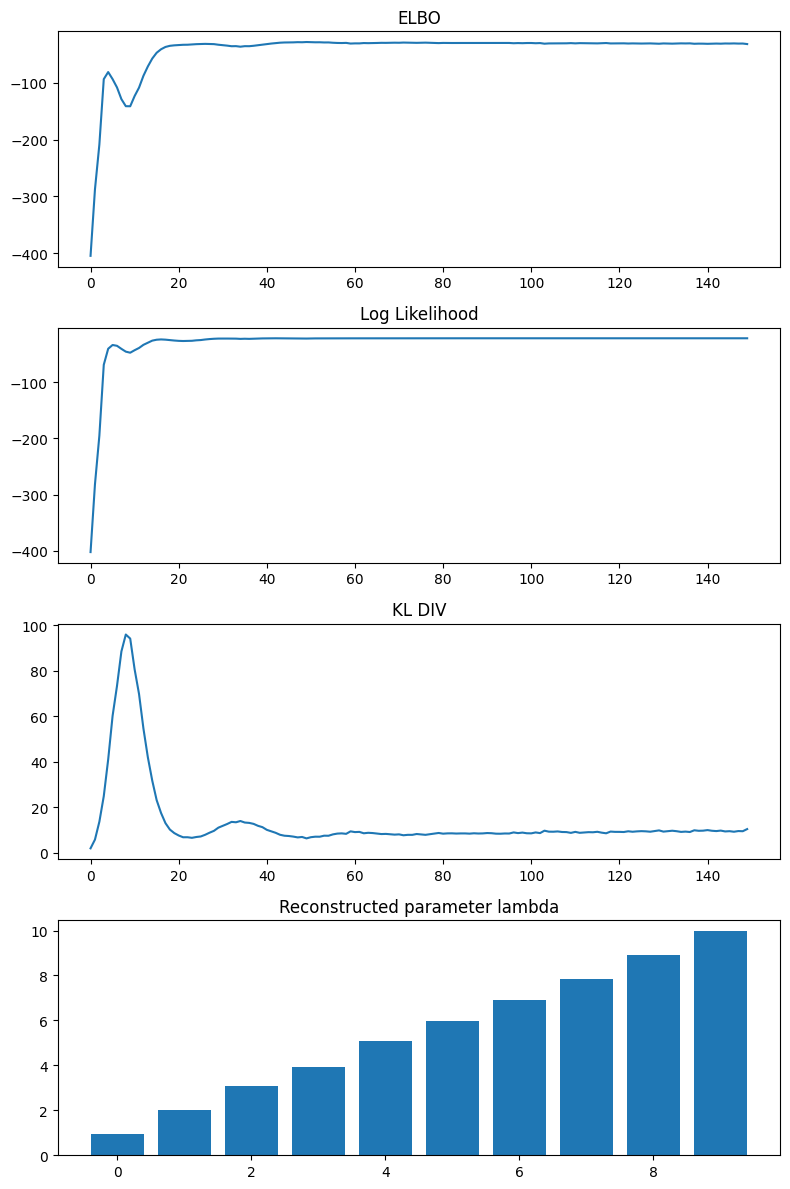

In [6]:
fig, axs = plt.subplots(4, 1, figsize=(8, 12))

axs[0].plot(elbo_values)
axs[0].set_title('ELBO')

axs[1].plot(log_likelihoods)
axs[1].set_title('Log Likelihood')

axs[2].plot(kl_div)
axs[2].set_title('KL DIV')

axs[3].bar(range(10), output.detach().cpu().numpy())
axs[3].set_title('Reconstructed parameter lambda')

plt.tight_layout()

#plt.savefig('../out/vae_on_synthetic.png')

plt.show()

## 2. Test the VAE on real gene expression dataset:
In this part we test our model on the MBC-20k dataset which contains 20 000 cells and 27 998 features each, and split it into train and
test sets with proportion 81% train and 19% test

In [4]:
#load the  MBC-20k dataset:
data= torch.load( '/content/drive/MyDrive/pgm_projet/new_scratch/models/big_datasets/MBC_20k.pt') # put your correct path
train_data, test_data = train_test_split(data, test_size = 0.19, random_state=0)
print('Size of the train set: {} \n Size of the test set: {}'.format(train_data.shape, test_data.shape))

train_dataloader = DataLoader(train_data, batch_size=100, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=100, shuffle=False)

Size of the train set: torch.Size([16200, 27998]) 
 Size of the test set: torch.Size([3800, 27998])


In [5]:
save_path='/content/drive/MyDrive/pgm_projet/new_scratch/checkpoints'
log_path = '/content/drive/MyDrive/pgm_projet/new_scratch/runs'
path='/content/drive/MyDrive/pgm_projet/new_scratch/grid_search'
result_path='/content/drive/MyDrive/pgm_projet/new_scratch/results'
grid_path='/content/drive/MyDrive/pgm_projet/new_scratch/grid_search'

###2.1 Grid search:
We train the network on one epoch for multiple hidden layers with number of units varrying in 100, 250, 500 and 1000, in adtition to changing the latent dimension of z from 0, 25, 50, to 100 as reported in the article

In [6]:
#define function for grid search
def grid_search_vae(par_dict, dist_name, n_features, path, log_path, ):
    """
    Perform a grid search for hyperparameters of a Variational AutoEncoder (VAE).

    Parameters:
    - par_dict (dict): Dictionary containing hyperparameter values to search.
    - dist_name (str): Name of the distribution used in the VAE.
    - n_features (int): Number of input features.
    - path (str): Path for saving grid search results.

    Returns:
    - dict: Dictionary containing grid search results, including hyperparameter values and corresponding metrics.
    """
    # Initialize a dictionary with default values as lists
    grid_result = defaultdict(list)

    # Initialize variables for best elbo, log likelihood, and kl divergence
    best_elbo, best_log_likeli, best_kl_div = 0, 1e8, 1e8

    # Iterate over hyperparameter combinations
    for lr in par_dict['lr']:
        for encoder_hidden_sizes in par_dict['encoder_hidden']:
            for decoder_hidden_sizes in par_dict['decoder_hidden']:
                for latent_dim in par_dict['latent_dim']:
                    # Create a Variational AutoEncoder with the current hyperparameters
                    my_vae = VariationalAutoEncoder(
                        input_size=n_features,
                        latent_dim=latent_dim,
                        encoder_hidden_sizes=encoder_hidden_sizes,
                        decoder_hidden_sizes=decoder_hidden_sizes,
                        dist_name=dist_name,
                        return_latent=True
                    )
                    my_vae.to(device)

                    # Train the model for one epoch
                    elbo_values, log_likelihoods, kl_div, z_values = train(
                        my_vae,
                        train_dataloader,
                        lr=lr, weight_decay=5e-2,
                        nb_epochs=1,
                        log_path= log_path,
                        save_path= grid_path
                        device=device
                    )

                    # Append results to the grid_result dictionary
                    grid_result['encoder_hidden_sizes'].append(encoder_hidden_sizes)
                    grid_result['decoder_hidden_sizes'].append(decoder_hidden_sizes)
                    grid_result['latent_dim'].append(latent_dim)
                    grid_result['elbo'].append(elbo_values)
                    grid_result['log_likeli'].append(log_likelihoods)
                    grid_result['kl_div'].append(kl_div)

                    # Save the grid result (uncomment if needed)
                    # with open(os.path.join(path, f'grid_{dist}.json'), 'w') as f:
                    #     json.dump(grid_result, f)

    return grid_result

Perform the grid search:

In [ ]:
# Path to store grid search results

# Number of input features
n_features = 27998

# Hyperparameter dictionary
parameters_dict = {
    'lr': [0.0001],
    'encoder_hidden': [[100], [100, 250], [100, 250, 500], [100, 250, 500, 1000]],
    'decoder_hidden':  [[100], [100, 250], [100, 250, 500], [100, 250, 500, 1000]],
    'latent_dim': [10, 25, 50, 100]
}

# Iterate over different distributions
for dist in ['Poisson', 'NB', 'ZIP', 'ZINB']:
    print(f"\ndist: {dist}")
    result = grid_search_vae(parameters_dict, dist, n_features, grid_path, log_path)

    # Save the grid search result to a JSON file
    with open(os.path.join(path, f'grid_{dist}.json'), 'w') as f:
        json.dump(result, f)


###2.2 Training the VAE

Import the grids and analyse the best combinations

In [ ]:
# Train the model on these configurations:
lr = 1e-4
n_features= 27998
for dist in ['NB', 'ZIP', 'ZINB','Poisson']:
    #load grid search results
    with open(os.path.join(grid_path, f'grid_{dist}.json'), 'r') as f:
        result_dist = json.load(f)

    # Display best parameters
    print('\n The best parameters for {} are:'.format(dist))
    for key in result_dist.keys():
        print(key, result_dist[key][result_dist['elbo'].index(max(result_dist['elbo']))])

    # Get parameters for the best ELBO
    best_combi_index = result_dist['elbo'].index(max(result_dist['elbo']))

    # Create a Variational AutoEncoder with the best hyperparameters
    my_vae = VariationalAutoEncoder(
        input_size=n_features,
        latent_dim=result_dist['latent_dim'][best_combi_index],
        encoder_hidden_sizes=result_dist['decoder_hidden_sizes'][best_combi_index],
        decoder_hidden_sizes=result_dist['decoder_hidden_sizes'][best_combi_index],
        dist_name=dist,
        return_latent='True'
    )
    my_vae.to(device)

    # Train the model
    elbo_values, log_likelihoods, kl_div, z_values, descs = train(
        my_vae,
        train_dataloader,
        lr=lr,
        weight_decay=5e-2,
        nb_epochs=200,
        log_path=log_path,
        save_path=save_path,
        dist=dist,
        device=device
    )

    # Results for training
    results_dist_train = {
        'elbo_values': elbo_values,
        'log_likelihoods': log_likelihoods,
        'kl_div': kl_div,
        'z_values': z_values
    }

    # Save results (uncomment if needed)
    # with open(os.path.join(result_path, f'train_result_{dist}.pickle'), 'wb') as f:
    #     pickle.dump(results_dist_train, f)

    # Plotting
    fig, axs = plt.subplots(3, 1, figsize=(8, 12))

    axs[0].plot(elbo_values)
    axs[0].set_title('ELBO')

    axs[1].plot(log_likelihoods)
    axs[1].set_title('Log Likelihood')

    axs[2].plot(kl_div)
    axs[2].set_title('KL DIV')

    plt.tight_layout()

    # Save or display the plot
    plt.savefig(os.path.join(result_path, 'vae_{}_train_results.png'.format(dist)))
    plt.show()


Tackle the non convergence of the model on the Poisson distribution by visualizing the sum of lambdas over epochs

In [ ]:
# Load lambda descriptors from a pickle file
dsit= 'Poisson'
with open(os.path.join(result_path, f'lambda_decriptors_sum_{dist}.pickle'), 'rb') as f:
    descs = pickle.load(f)

# Get the sum of lambdas at each epoch
n_batch = 162
descs_ep = [descs[i: i + n_batch] for i in range(0, len(descs), n_batch)]
sum_lambda_epoch = []

# Iterate through epochs and batches to calculate the sum of lambdas
for ep_desc in descs_ep:
    sum_lambda_epoch.append(sum([b_desc[0]['sum'] for b_desc in ep_desc]))

# Plot the results
plt.figure()
plt.plot(sum_lambda_epoch)
plt.xlabel('Epochs')
plt.ylabel('Sum of Lambdas')
plt.savefig(os.path.join(result_path, 'sum_lambda_epoch.png'))
plt.show()

Display elbo values for all the distributions:

In [ ]:
plt.figure()

# Iterate through different distributions
for dist in ['NB', 'ZIP', 'ZINB']:
    # Load training results for the current distribution
    with open(os.path.join(result_path, f'train_result_{dist}.pickle'), 'rb') as f:
        results_dist_train = pickle.load(f)

    # Extract ELBO values from the results
    elbo = results_dist_train['elbo_values']

    # Plot ELBO values for the current distribution
    plt.plot(elbo, label=dist)

# Set x and y labels
plt.xlabel('Epochs')
plt.ylabel('ELBO')

# Set y-axis limits
plt.ylim(-16000, -5000)

# Add legend to the plot
plt.legend()

# Save the plot to a file
plt.savefig(os.path.join(save_path, 'all_elbos.png'))

### 2.3 Test
We run the VAE on the test set created earlier and record the results for all distributions:

In [ ]:

for dist in ['NB', 'ZIP', 'ZINB','Poisson']:
  with open(os.path.join(path, f'grid_{dist}.json'), 'r') as f:
    result_dist= json.load(f)

  # display parameters:
  print('\n The best parameters are:')
  for key in result_dist.keys():
    print(key, result_dist[key][result_dist['elbo'].index(max(result_dist['elbo']))])

  #get parameters for best elbo
  best_combi_index= result_dist['elbo'].index(max(result_dist['elbo']))

  my_vae = VariationalAutoEncoder(input_size=n_features,
                                  latent_dim=result_dist['latent_dim'][best_combi_index], # last inf hidden dim
                                  encoder_hidden_sizes=result_dist['encoder_hidden_sizes'][best_combi_index],
                                  decoder_hidden_sizes=result_dist['decoder_hidden_sizes'][best_combi_index],
                                  dist_name=dist,
                                  return_latent= 'True')
  my_vae.to(device)
  elbo_value, z_values = test(my_vae,
                              test_dataloader,
                              log_path= log_path,
                              save_path = save_path,
                              dist = dist,
                              device=device)
  #store test elbo and latent variables

  results_dist_test= {
      'elbo_value': elbo_value,
      'z_values': z_values
  }

  with open(os.path.join(result_path, f'test_result_{dist}.pickle'), 'wb') as f:
      pickle.dump(results_dist_test, f)

  print('test elbo for {} distribution: {}'.format(dist, elbo_value))

### 2.3 GMVAE

In [ ]:
# synthetic dataset creation
nb_cat = 5
N_samples = 10000
dataset = distri.Poisson(torch.tensor([i for i in range(1, 11)], dtype=torch.float)).sample((N_samples,))
model = KMeans(n_clusters=nb_cat, random_state=0)
model.fit(dataset)
print("\nClustering done !")
categories = torch.tensor(model.predict(dataset))
prop = torch.unique(categories, return_counts=True)[1]/N_samples

# model instanciation
my_gmvae = GMVariationalAutoEncoder(input_size=dataset.shape[1],
                                latent_dim=3,
                                nb_cat=nb_cat,
                                encoder_hidden_sizes=[7],
                                pi_hidden_sizes=[10],
                                decoder_hidden_sizes=[7]
                                )

# code for ablation study
elbo_values, good_prediction_terms, regularization_terms, crossentropy_losses, output, pi = gm_train(my_gmvae,
                                                                                                     dataset,
                                                                                                     categories,
                                                                                                     lr=0.08,
                                                                                                     weight_decay=5e-2,
                                                                                                     nb_epochs=200,
                                                                                                     regularization_method = "kl")

print(f"\nclusters prop: {prop}")

In [ ]:
# to visualize the results
save_path = "" # put the path for saving results
fig, axs = plt.subplots(3, 2, figsize=(8, 12))

axs[0,0].plot(elbo_values)
axs[0,0].set_title('ELBO')

axs[0,1].plot(good_prediction_terms)
axs[0,1].set_title('Good prediction term')

axs[1,0].plot(regularization_terms)
axs[1,0].set_title('Regularization term')

axs[1,1].plot(crossentropy_losses)
axs[1,1].set_title('Cross entropy of y')

axs[2,0].bar(range(10), output.detach().numpy())
axs[2,0].set_title('Reconstructed parameter lambda')

bar_width = 0.35
axs[2,1].bar(np.array([i for i in range(nb_cat)])- bar_width/2, pi.detach().cpu().numpy(), width=bar_width, label = "Predicted")
axs[2,1].bar(np.array([i for i in range(nb_cat)])+ bar_width/2, prop.detach().cpu().numpy(), width=bar_width, label = "Real")
axs[2,1].set_title('Classes probability vector')
axs[2,1].legend()

plt.tight_layout()

plt.savefig(save_path)

plt.show()